### Sources used
1. EXAMPLE ON HOW TO IMPLEMENT THE DATASETS: https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html
2. LOOK AHEAD BIAS EXPLANATION: https://stats.stackexchange.com/questions/442739/look-ahead-bias-induced-by-standardization-of-a-time-series#:~:text=Yes%20this%20is%20considered%20a,will%20not%20have%20this%20information.
3. Simple yt vid explanation: https://www.youtube.com/watch?v=q_HS4s1L8UI&t=428s

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from pytorch_forecasting import TimeSeriesDataSet
from tqdm.autonotebook import tqdm
import copy
from pathlib import Path
import warnings
import matplotlib.pyplot as plt

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from torch import nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

c:\Users\r0776327\AppData\Local\miniconda3\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv("Datasets/Dataframes_one_ex_var/ModelBenchmark_dataframe.csv")
df.head(), df.shape

(                  Date  Price  FR Generation  FR Load
 0  2018-01-01 00:00:00   4.74        53625.0  56250.0
 1  2018-01-01 01:00:00   3.66        52398.0  54300.0
 2  2018-01-01 02:00:00   1.26        51825.0  53600.0
 3  2018-01-01 03:00:00 -20.10        50729.0  50000.0
 4  2018-01-01 04:00:00 -31.82        50719.0  47100.0,
 (43824, 4))

In [3]:
# Set Date as index
df.Date = pd.to_datetime(df.Date)

df.head()

,Date,Price,FR Generation,FR Load
0,2018-01-01 00:00:00,4.74,53625.0,56250.0
1,2018-01-01 01:00:00,3.66,52398.0,54300.0
2,2018-01-01 02:00:00,1.26,51825.0,53600.0
3,2018-01-01 03:00:00,-20.10,50729.0,50000.0
4,2018-01-01 04:00:00,-31.82,50719.0,47100.0


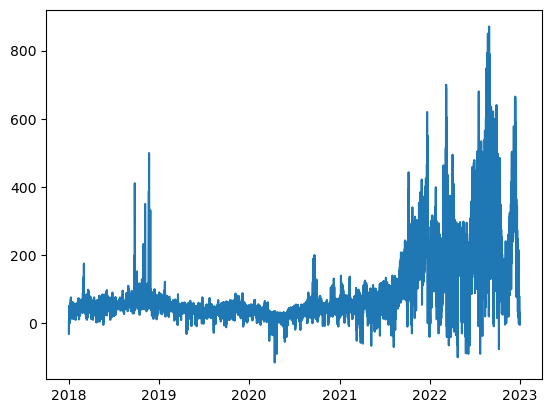

In [4]:
plt.plot(df["Date"], df["Price"])
plt.show()

In [5]:
df.head(), df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           43824 non-null  datetime64[ns]
 1   Price          43824 non-null  float64       
 2   FR Generation  43824 non-null  float64       
 3   FR Load        43824 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.3 MB


(                 Date  Price  FR Generation  FR Load
 0 2018-01-01 00:00:00   4.74        53625.0  56250.0
 1 2018-01-01 01:00:00   3.66        52398.0  54300.0
 2 2018-01-01 02:00:00   1.26        51825.0  53600.0
 3 2018-01-01 03:00:00 -20.10        50729.0  50000.0
 4 2018-01-01 04:00:00 -31.82        50719.0  47100.0,
 None,
 (43824, 4))

In [6]:
from copy import deepcopy as dc

def prepare_dataframe_laggs(df, n_steps):
    df = dc(df)
    df.set_index("Date", inplace=True)

    for i in range(1,n_steps+1):
        df[f'Price(t-{i})'] = df["Price"].shift(i)

    df.dropna(inplace=True)
    return df

In [7]:
# df_train = df[df["Date"] < "2021-01-01"]
# df_test = df[df["Date"] >= "2021-01-01"]
# df_train.shape, df_test.shape

In [8]:
lookback = 7
lagged_df = prepare_dataframe_laggs(df, lookback)
lagged_df.head(), lagged_df.shape

(                     Price  FR Generation  FR Load  Price(t-1)  Price(t-2)  \
 Date                                                                         
 2018-01-01 07:00:00 -19.33        53045.0  46000.0      -13.71      -28.66   
 2018-01-01 08:00:00 -15.78        54371.0  46400.0      -19.33      -13.71   
 2018-01-01 09:00:00 -12.05        54318.0  46950.0      -15.78      -19.33   
 2018-01-01 10:00:00  -0.42        54495.0  49100.0      -12.05      -15.78   
 2018-01-01 11:00:00   2.30        54726.0  51500.0       -0.42      -12.05   
 
                      Price(t-3)  Price(t-4)  Price(t-5)  Price(t-6)  \
 Date                                                                  
 2018-01-01 07:00:00      -31.82      -20.10        1.26        3.66   
 2018-01-01 08:00:00      -28.66      -31.82      -20.10        1.26   
 2018-01-01 09:00:00      -13.71      -28.66      -31.82      -20.10   
 2018-01-01 10:00:00      -19.33      -13.71      -28.66      -31.82   
 2018-01-01 1

In [9]:
lagged_df_np = lagged_df.to_numpy()
lagged_df_np

array([[-1.9330e+01,  5.3045e+04,  4.6000e+04, ...,  1.2600e+00,
         3.6600e+00,  4.7400e+00],
       [-1.5780e+01,  5.4371e+04,  4.6400e+04, ..., -2.0100e+01,
         1.2600e+00,  3.6600e+00],
       [-1.2050e+01,  5.4318e+04,  4.6950e+04, ..., -3.1820e+01,
        -2.0100e+01,  1.2600e+00],
       ...,
       [ 2.3900e+00,  4.4578e+04,  5.0450e+04, ...,  2.6910e+01,
         1.4880e+01,  1.6700e+01],
       [ 1.3000e-01,  4.5135e+04,  4.9650e+04, ...,  2.7930e+01,
         2.6910e+01,  1.4880e+01],
       [-4.3900e+00,  4.2280e+04,  4.6950e+04, ...,  2.2090e+01,
         2.7930e+01,  2.6910e+01]])

In [10]:
lagged_df.head()

,Price,FR Generation,FR Load,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7)
Date,,,,,,,,,,
2018-01-01 07:00:00,-19.33,53045.0,46000.0,-13.71,-28.66,-31.82,-20.10,1.26,3.66,4.74
2018-01-01 08:00:00,-15.78,54371.0,46400.0,-19.33,-13.71,-28.66,-31.82,-20.10,1.26,3.66
2018-01-01 09:00:00,-12.05,54318.0,46950.0,-15.78,-19.33,-13.71,-28.66,-31.82,-20.10,1.26
2018-01-01 10:00:00,-0.42,54495.0,49100.0,-12.05,-15.78,-19.33,-13.71,-28.66,-31.82,-20.10
2018-01-01 11:00:00,2.30,54726.0,51500.0,-0.42,-12.05,-15.78,-19.33,-13.71,-28.66,-31.82


In [11]:
from sklearn.preprocessing import MinMaxScaler
# Transform features by scaling each feature to a given range. 
scaler = MinMaxScaler(feature_range=(-1,1))
lagged_df_np = scaler.fit_transform(lagged_df_np)
lagged_df_np

array([[-0.80537559, -0.19601584, -0.4871407 , ..., -0.76362401,
        -0.75875739, -0.75656741],
       [-0.79817704, -0.15531477, -0.47503782, ..., -0.80693697,
        -0.76362401, -0.75875739],
       [-0.7906135 , -0.15694159, -0.45839637, ..., -0.83070231,
        -0.80693697, -0.76362401],
       ...,
       [-0.76133264, -0.45590718, -0.35249622, ..., -0.71161197,
        -0.73600592, -0.7323154 ],
       [-0.76591538, -0.43881028, -0.37670197, ..., -0.70954365,
        -0.71161197, -0.73600592],
       [-0.77508086, -0.52644341, -0.45839637, ..., -0.72138577,
        -0.70954365, -0.71161197]])

In [12]:
X = lagged_df_np[:, 1:]
y = lagged_df_np[:, 0]
X.shape, y.shape

((43817, 9), (43817,))

In [13]:
X = dc(np.flip(X, axis=1))
X

array([[-0.75656741, -0.75875739, -0.76362401, ..., -0.79397958,
        -0.4871407 , -0.19601584],
       [-0.75875739, -0.76362401, -0.80693697, ..., -0.80537559,
        -0.47503782, -0.15531477],
       [-0.76362401, -0.80693697, -0.83070231, ..., -0.79817704,
        -0.45839637, -0.15694159],
       ...,
       [-0.7323154 , -0.73600592, -0.71161197, ..., -0.75559408,
        -0.35249622, -0.45590718],
       [-0.73600592, -0.71161197, -0.70954365, ..., -0.76133264,
        -0.37670197, -0.43881028],
       [-0.71161197, -0.70954365, -0.72138577, ..., -0.76591538,
        -0.45839637, -0.52644341]])

In [14]:
split_index = int(len(X)*0.95)
split_index

41626

In [15]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41626, 9), (2191, 9), (41626,), (2191,))

In [16]:
X_train = X_train.reshape((-1, lookback+2, 1))
X_test = X_test.reshape((-1, lookback+2, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41626, 9, 1), (2191, 9, 1), (41626, 1), (2191, 1))

In [17]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([41626, 9, 1]),
 torch.Size([2191, 9, 1]),
 torch.Size([41626, 1]),
 torch.Size([2191, 1]))

In [18]:
from helper_functions.data_setup import TimeseriesDataset

# class TimeseriesDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y

#     def __len__(self):
#         return len(self.X)
    
#     def __getitem__(self, i):
#         return self.X[i],self.y[i]
    
train_dataset = TimeseriesDataset(X_train, y_train)
test_dataset = TimeseriesDataset(X_test, y_test)

In [19]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 9, 1]) torch.Size([16, 1])


In [22]:
from helper_functions.model_builder import LSTM

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [24]:
def train_one_epoch(epoch, loss_function, optimizer):
    model.train(True)
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index %100 == 99: #print every 100 batches
            avg_loss_accross_batches = running_loss / 100
            print("Batch {0}, Avg Loss {1:.3f}".format(batch_index+1, avg_loss_accross_batches))

            running_loss = 0.0

    print()

In [26]:
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(16, 4, 1), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LSTM (LSTM)                              [16, 4, 1]           [16, 1]              --                   True
├─LSTM (lstm)                            [16, 4, 1]           [16, 4, 4]           112                  True
├─Linear (fc)                            [16, 4]              [16, 1]              5                    True
Total params: 117
Trainable params: 117
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [25]:
def validate_one_epoch(epoch, loss_function):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    avg_loss_accross_batches = running_loss / len(test_loader)

    print("Val Loss: {0:.3f}".format(avg_loss_accross_batches))
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
    print()

In [150]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(epoch, loss_function, optimizer)
    validate_one_epoch(epoch, loss_function)

Epoch: 1
Batch 100, Avg Loss 0.004
Batch 200, Avg Loss 0.004
Batch 300, Avg Loss 0.003
Batch 400, Avg Loss 0.003
Batch 500, Avg Loss 0.003
Batch 600, Avg Loss 0.003
Batch 700, Avg Loss 0.003
Batch 800, Avg Loss 0.003
Batch 900, Avg Loss 0.003
Batch 1000, Avg Loss 0.003
Batch 1100, Avg Loss 0.002
Batch 1200, Avg Loss 0.002
Batch 1300, Avg Loss 0.002
Batch 1400, Avg Loss 0.002
Batch 1500, Avg Loss 0.002
Batch 1600, Avg Loss 0.002
Batch 1700, Avg Loss 0.002
Batch 1800, Avg Loss 0.002
Batch 1900, Avg Loss 0.002
Batch 2000, Avg Loss 0.002
Batch 2100, Avg Loss 0.001
Batch 2200, Avg Loss 0.002
Batch 2300, Avg Loss 0.002
Batch 2400, Avg Loss 0.002
Batch 2500, Avg Loss 0.002
Batch 2600, Avg Loss 0.002

Val Loss: 0.006
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

Epoch: 2
Batch 100, Avg Loss 0.002
Batch 200, Avg Loss 0.002
Batch 300, Avg Loss 0.002
Batch 400, Avg Loss 0.002
Batch 500, Avg Loss 0.002
Batch 600, Avg Loss 0.002
Batch 700, Avg Loss 0.002
Batch 800, Avg Loss 0.002
Batch 900, Avg L

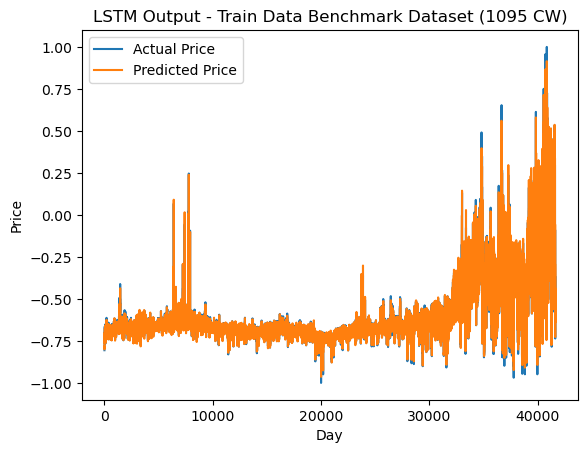

In [34]:
# WRONG SCALE

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label="Actual Price")
plt.plot(predicted, label='Predicted Price')
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("LSTM Output - Train Data Benchmark Dataset (1095 CW)")
plt.legend()
plt.show()

In [36]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+3))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ -8.10917756, -16.80807638, -13.9194957 , ...,  66.52984222,
        77.41635516, 160.79098727])

In [37]:
dummies = np.zeros((X_train.shape[0], lookback+3))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([-19.32999219, -15.78000973, -12.04998701, ...,  71.63998746,
       137.79999271, 195.05000376])

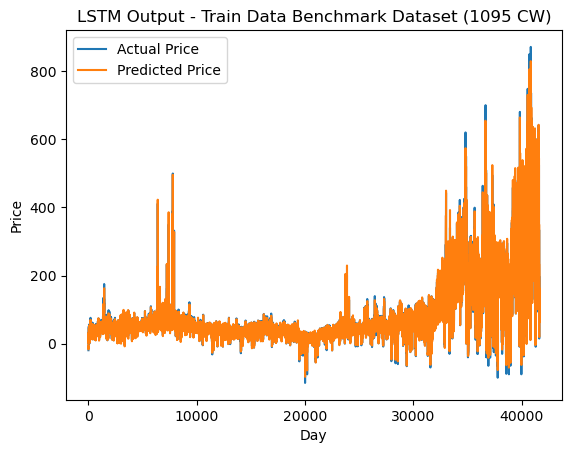

In [38]:
plt.plot(new_y_train, label="Actual Price")
plt.plot(train_predictions, label='Predicted Price')
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("LSTM Output - Train Data Benchmark Dataset (1095 CW)")
plt.legend()
plt.show()

In [155]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+3))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])
test_predictions

array([220.65637342, 245.73862749, 209.15884058, ...,   0.52143823,
        -0.32617663,  -0.78819669])

In [156]:
dummies = np.zeros((X_test.shape[0], lookback+3))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 2.29299996e+02,  2.18650005e+02,  1.72899996e+02, ...,
        2.39000630e+00,  1.29993956e-01, -4.39000135e+00])

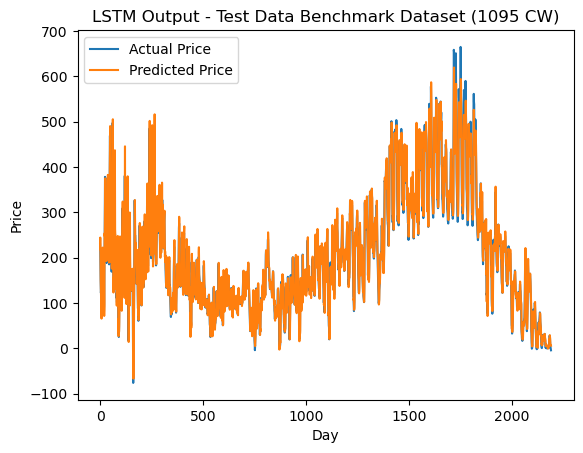

In [39]:
plt.plot(new_y_test, label="Actual Price")
plt.plot(test_predictions, label='Predicted Price')
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("LSTM Output - Test Data Benchmark Dataset (1095 CW)")
plt.legend()
plt.show()

In [29]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      # avg_loss_accross_batches = train_loss / 100
      train_acc += mae(y_pred.detach().cpu().numpy(), y.cpu().numpy())
      # y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred, y)
          test_loss += loss.item()          
          
          # Calculate and accumulate accuracy
          # test_acc += mae(test_pred.detach(), y)
          test_acc += mae(test_pred.detach().cpu().numpy(), y.cpu().numpy())
          # test_pred_labels = test_pred_logits.argmax(dim=1)
          # test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train MAE: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test MAE: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [30]:
# # from helper_functions.engine import train

learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training with help from engine.py
train(model=model,
             train_dataloader=train_loader,
             test_dataloader=test_loader,
             loss_fn=loss_function,
             optimizer=optimizer,
             epochs=10,
             device=device)

 10%|█         | 1/10 [00:04<00:43,  4.88s/it]

Epoch: 1 | train_loss: 0.0013 | train MAE: 0.0189 | test_loss: 0.0041 | test MAE: 0.0424


 20%|██        | 2/10 [00:09<00:38,  4.77s/it]

Epoch: 2 | train_loss: 0.0013 | train MAE: 0.0189 | test_loss: 0.0039 | test MAE: 0.0405


 30%|███       | 3/10 [00:14<00:33,  4.85s/it]

Epoch: 3 | train_loss: 0.0013 | train MAE: 0.0188 | test_loss: 0.0041 | test MAE: 0.0413


 40%|████      | 4/10 [00:19<00:28,  4.78s/it]

Epoch: 4 | train_loss: 0.0013 | train MAE: 0.0187 | test_loss: 0.0039 | test MAE: 0.0404


 50%|█████     | 5/10 [00:23<00:23,  4.70s/it]

Epoch: 5 | train_loss: 0.0013 | train MAE: 0.0186 | test_loss: 0.0040 | test MAE: 0.0411


 60%|██████    | 6/10 [00:28<00:18,  4.65s/it]

Epoch: 6 | train_loss: 0.0013 | train MAE: 0.0186 | test_loss: 0.0039 | test MAE: 0.0410


 70%|███████   | 7/10 [00:33<00:14,  4.69s/it]

Epoch: 7 | train_loss: 0.0013 | train MAE: 0.0187 | test_loss: 0.0039 | test MAE: 0.0407


 80%|████████  | 8/10 [00:37<00:09,  4.69s/it]

Epoch: 8 | train_loss: 0.0013 | train MAE: 0.0187 | test_loss: 0.0039 | test MAE: 0.0409


 90%|█████████ | 9/10 [00:42<00:04,  4.70s/it]

Epoch: 9 | train_loss: 0.0013 | train MAE: 0.0185 | test_loss: 0.0040 | test MAE: 0.0409


100%|██████████| 10/10 [00:46<00:00,  4.69s/it]

Epoch: 10 | train_loss: 0.0013 | train MAE: 0.0184 | test_loss: 0.0039 | test MAE: 0.0408


{'train_loss': [0.0012959080186576786,
  0.0012913495030596259,
  0.0012842619621422093,
  0.0012751043040463725,
  0.0012683708413977778,
  0.0012597397274396957,
  0.0012706524349211103,
  0.0012713745875965207,
  0.0012625885055136058,
  0.0012597196606897437],
 'train_acc': [0.018941460914629227,
  0.01888791363071407,
  0.01883804332107008,
  0.018713966540657243,
  0.018631688528354184,
  0.01855055685548812,
  0.0186941227374554,
  0.01869422459916185,
  0.01848560854020191,
  0.018440153311972407],
 'test_loss': [0.0041400417927686586,
  0.003907781361664278,
  0.004052128362593438,
  0.003867141137249686,
  0.003970383292460903,
  0.003930654719193214,
  0.003869569924342222,
  0.003883062657495675,
  0.003960793149609961,
  0.003930460548845807],
 'test_acc': [0.042358320580292354,
  0.04052824805742198,
  0.0413093467712076,
  0.04043555821897122,
  0.041062354633625404,
  0.04104523750932983,
  0.040731220077859225,
  0.0408719972482998,
  0.0409393318160607,
  0.0408163745

In [ ]:
# Epoch: 10 | train_loss: 0.0013 | train_acc: 0.0187 | test_loss: 0.0040 | test_acc: 0.0420

In [31]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+3))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])
test_predictions

dummies = np.zeros((X_test.shape[0], lookback+3))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 2.29299996e+02,  2.18650005e+02,  1.72899996e+02, ...,
        2.39000630e+00,  1.29993956e-01, -4.39000135e+00])

In [32]:
mae(new_y_test, test_predictions)

20.135833019346432